# Guide to RNN with Keras


RNN stands for **Recurrent Neural Networks.**


In this Notebook, we discuss **Recurrent Neural Networks**, a class of neural networks that discover the sequential nature of the input data. Inputs could be of text, speech, time series and anything else where sequence matters. We will discuss SimpleRNN cell, its major limitation, RNN topologies, variants of the SimpleRNN cell - **Long Short Term Memory (LSTM)**, **Gated Recurrent Unit (GRU)** and other RNN variants.


We will also see basic RNN implementation in Keras in generating text.

<a class="anchor" id="0.1"></a>
# Table of Contents


1. [Introduction to Recurrent Neural Network (RNN)](#1)
1. [RNN Computations](#2)
1. [SimpleRNN cells](#3)
1. [Implementation of SimpleRNN with Keras - text generation](#4)
1. [RNN topologies](#5)
1. [Vanishing and exploding gradients](#6)
1. [Long Short Term Memory (LSTM)](#7)
1. [Summary and conclusion](#9)
1. [References](#10)

# 1. Introduction to Recurrent Neural Network (RNN) <a class="anchor" id="1"></a>


[Back to Table of Contents](#0.1)


- **Recurrent Neural Networks (RNNs)** are a family of networks that are suitable for learning representations of sequential data like text in Natural Language Processing (NLP).

- The idea behind RNNs is to make use of sequential information. 

- In a traditional neural network we assume that all inputs (and outputs) are independent of each other. 

- But for many tasks that is a very bad idea. If we want to predict the next word in a sentence we better know which words came before it. 

- RNNs are called recurrent because they perform the same task for every element of a sequence, with the output being depended on the previous computations. 

- Another way to think about RNNs is that they have a “memory” which captures information about what has been calculated so far. 

- In theory RNNs can make use of information in arbitrarily long sequences, but in practice they are limited to looking back only a few steps. 

- Here is what a typical RNN looks like:






RNN-unrolled.png

- The above diagram shows a RNN being unrolled (or unfolded) into a full network. 

- By unrolling we simply mean that we write out the network for the complete sequence. 

- For example, if the sequence we care about is a sentence of 5 words, the network would be unrolled into a 5-layer neural network, one layer for each word.

- Please follow the link below for in-depth discussion on RNN.

[Recurrent Neural Network from Wikipedia](https://en.wikipedia.org/wiki/Recurrent_neural_network)

# 2. RNN Computations <a class="anchor" id="2"></a>

[Back to Table of Contents](#0.1)

- We can describe the computations within an RNN in terms of equations. 

- The internal state of the RNN at a time t is given by the value of the hidden vector ht, which is the sum of the product of the weight matrix W and the hidden state ht-1 at time t-1 and the product of the weight matrix U and the input xt at time t, passed through the tanh nonlinearity. 

- The choice of tanh over other nonlinearities has to do with its second derivative decaying very slowly to zero. 

- This keeps the gradients in the linear region of the activation function and helps combat the vanishing gradient problem. 

- The output vector yt at time t is the product of the weight matrix V and the hidden state ht, with softmax applied to the product so the resulting vector is a set of output probabilities:
      

- Keras provides the SimpleRNN (for more information refer to: https://keras.io/layers/recurrent/) recurrent layer that incorporates all the logic we have seen so far, as well as the more advanced variants such as LSTM and GRU that we will see later in this kernel.

# 3. SimpleRNN cells <a class="anchor" id="3"></a>


[Back to Table of Contents](#0.1)


- Traditional multilayer perceptron neural networks make the assumption that all inputs are independent of each other. This assumption breaks down in the case of sequence data. 

- Time series data, such as stock prices, also exhibit a dependence on past data, called the secular trend.

- RNN cells incorporate this dependence by having a hidden state, or memory, that holds the essence of the past. 

- The value of the hidden state at any point in time is a function of the value of the hidden state at the previous time step and the value of the input at the current time step, that is:
        

  - ht and ht-1 are the values of the hidden states at the time steps t and t-1 respectively, and xt is the value of the input at time t. 
  
  - The above equation is recursive, that is, ht-1 can be represented in terms of ht-2 and xt-1, and so on, until the beginning of the sequence. 
  
- This is how RNNs encode and incorporate information from arbitrarily long sequences.


# 4.Implementation of SimpleRNN with Keras - text classification <a class="anchor" id="4"></a>

[Back to Table of Contents](#0.1)




- Let's check the file

- Then we import the necessary modules as follows:

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Model
from keras.layers import SimpleRNN, Activation, Dense, Dropout, Input, Embedding, LSTM
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

- As the file contains line breaks and non-ASCII characters, so we should do some preliminary cleanup and write out the contents into a variable called text as follows:

In [6]:
df = pd.read_csv('/content/spam.csv',delimiter=',',encoding='latin-1')
df.head()

v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN

In [7]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Number of ham and spam messages')

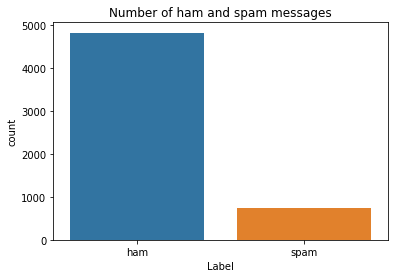

In [8]:
sns.countplot(df.v1)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

In [9]:
X = df.v2
Y = df.v1
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [10]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2)

### Process the data
* Tokenize the data and convert the text to sequences.
* Add padding to ensure that all the sequences have the same shape.
* There are many ways of taking the *max_len* and here an arbitrary length of 150 is chosen.

In [11]:
max_words = 1000
max_len = 150

tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)

sequences = tok.texts_to_sequences(X_train)


sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [33]:
sequences_matrix.shape

(4457, 150)

In [41]:
X_train[1]

'Ok lar... Joking wif u oni...'

In [42]:
sequences[0]

[35, 114, 3, 339, 1, 60, 227, 148, 21]

In [13]:
for i in range(10):
    print(len(sequences[i]))

9
10
15
21
7
6
19
23
7
22


In [14]:
for i in range(10):
    print(len(sequences_matrix[i]))

150
150
150
150
150
150
150
150
150
150


In [44]:
sequences_matrix[2]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  39,  16,   5,   7,  18,   5,   7,   1,
       541,   8,  16,   4,  55,  15, 116], dtype=int32)

In [16]:
len(sequences_matrix[0])

150

In [17]:
X_train[0]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

### RNN
Define the RNN structure.

In [46]:
def RNNmodel():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)

    layer = SimpleRNN(64)(layer)

    layer = Dense(256,name='FC1',activation='relu')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)

    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

Call the function and compile the model.

In [27]:
import tensorflow as tf

In [47]:
model = RNNmodel()
model.summary()
model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy',tf.keras.metrics.Precision()])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 150, 50)           50000     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                7360      
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation_4 (Activation)   (None, 256)               0         
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257 

Fit on the training data.

In [48]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10, validation_split=0.2)

Epoch 1/10
28/28 [==============================] - 2s 44ms/step - loss: 0.4094 - accuracy: 0.8502 - precision_2: 0.1408 - val_loss: 0.3039 - val_accuracy: 0.8688 - val_precision_2: 0.0000e+00
Epoch 2/10
28/28 [==============================] - 1s 36ms/step - loss: 0.1822 - accuracy: 0.9374 - precision_2: 0.9676 - val_loss: 0.2004 - val_accuracy: 0.9226 - val_precision_2: 0.6446
Epoch 3/10
28/28 [==============================] - 1s 36ms/step - loss: 0.0741 - accuracy: 0.9770 - precision_2: 0.9465 - val_loss: 0.0813 - val_accuracy: 0.9787 - val_precision_2: 0.9083
Epoch 4/10
28/28 [==============================] - 1s 36ms/step - loss: 0.0467 - accuracy: 0.9865 - precision_2: 0.9759 - val_loss: 0.0485 - val_accuracy: 0.9843 - val_precision_2: 0.9813
Epoch 5/10
28/28 [==============================] - 1s 35ms/step - loss: 0.0303 - accuracy: 0.9902 - precision_2: 0.9807 - val_loss: 0.0510 - val_accuracy: 0.9765 - val_precision_2: 0.9898
Epoch 6/10
28/28 [==============================] -

The model performs well on the validation set and this configuration is chosen as the final model.

Process the test set data.

In [49]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

Evaluate the model on the test set.

In [50]:
accr = model.evaluate(test_sequences_matrix,Y_test)

35/35 [==============================] - 0s 5ms/step - loss: 0.0775 - accuracy: 0.9830 - precision_2: 0.9848


In [51]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.077
  Accuracy: 0.983


# 5. RNN topologies <a class="anchor" id="5"></a>

[Back to Table of Contents](#0.1)


- The APIs for MLP and CNN architectures are limited. Both architectures accept a fixed-size tensor as input and produce a fixed-size tensor as output; and they perform the transformation from input to output in a fixed number of steps given by the number of layers in the model. 

- RNNs don't have this limitation—you can have sequences in the input, the output, or both. This means that RNNs can be arranged in many ways to solve specific problems.

- RNNs combine the input vector with the previous state vector to produce a new state vector. This can be thought of as similar to running a program with some inputs and some internal variables. 

- The RNNs are more exciting because they allow us to operate over sequences of vectors: Sequences in the input, the output, or in the most general case both. 

- This property of being able to work with sequences gives rise to a number of common topologies shown below:

![Sequences of Vectors in RNNs](https://miro.medium.com/max/815/1*XosBFfduA1cZB340SSL1hg.png)

- In the above diagram each rectangle is a vector and arrows represent functions (e.g. matrix multiply). 

- Input vectors are in red, output vectors are in blue and green vectors hold the RNN’s state. 

- From left to right:

  - 1. Vanilla mode of processing without RNN, from fixed-sized input to fixed-sized output (e.g. image classification).
  
  - 2. Sequence output (e.g. image captioning takes an image and outputs a sentence of words).
  
  - 3. Sequence input (e.g. sentiment analysis where a given sentence is classified as expressing positive or negative sentiment).
  
  - 4. Sequence input and sequence output (e.g. Machine Translation: an RNN reads a sentence in English and then outputs a sentence in French).
  
  - 5. Synced sequence input and output (e.g. video classification where we wish to label each frame of the video).

# 6. Vanishing and exploding gradients <a class="anchor" id="6"></a>

[Back to Table of Contents](#0.1)


- Just like traditional neural networks, training the RNN also involves backpropagation. 

- The difference in this case is that since the parameters are shared by all time steps, the gradient at each output depends not only on the current time step, but also on the previous ones. 
 
- This process is called **backpropagation through time (BPTT)**.

- Regular RNNs might have a difficulty in learning long range dependencies.

- This kind of dependencies between sequence data is called long-term dependencies because the distance between the relevant information and the point where it is needed to make a prediction is very wide. 

- As this distance becomes wider, RNNs have a hard time learning these dependencies because it encounters either a vanishing or exploding gradient problem.

- These problems arise during training of a deep network when the gradients are being propagated back in time all the way to the initial layer.

- The gradients coming from the deeper layers have to go through continuous matrix multiplications because of the the chain rule, and as they approach the earlier layers, if they have small values (<1), they shrink exponentially until they vanish and make it impossible for the model to learn. This is the **vanishing gradient problem**.

- While on the other hand if they have large values (>1) they get larger and eventually blow up and crash the model. This is the **exploding gradient problem.**



- While there are a few approaches to minimize the problem of vanishing gradients, such as proper initialization of the W matrix, using a ReLU instead of tanh layers, and pre-training the layers using unsupervised methods, the most popular solution is to use the LSTM or GRU architectures (discussed next).

- These architectures have been designed to deal with the vanishing gradient problem and learn long term dependencies more effectively.

# 7. Long Short Term Memory (LSTM) <a class="anchor" id="7"></a>

[Back to Table of Contents](#0.1)


- **Long Short Term Memory** networks – usually just called **LSTMs** – are a special kind of RNN, capable of learning long-term dependencies. They work tremendously well on a large variety of problems, and are now widely used.

- LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behaviour.

- All recurrent neural networks have the form of a chain of repeating modules of neural network. In standard RNNs, this repeating module will have a very simple structure, such as a single tanh layer.

- The repeating module in a standard RNN contains a single layer as shown below:

![Repeating module in a standard RNN](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png)

- LSTMs also have this chain like structure, but the repeating module has a different structure. 

- Instead of having a single neural network layer, there are four, interacting in a very special way as shown below:

![LSTM Architecture](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)

I will not go into Mathematical details behind LSTM. I will do it in a future kernel.

# 8. Gated Recurrent Unit <a class="anchor" id="8"></a>

[Back to Table of Contents](#0.1)


- The GRU is a variant of the LSTM and was introduced by K. Cho.

- It retains the LSTM's resistance to the vanishing gradient problem, but its internal structure is simpler, and therefore is faster to train, since fewer computations are needed to make updates to its hidden state. 

- A Gated Recurrent Unit (GRU), as its name suggests, is a variant of the RNN architecture, and uses gating mechanisms to control and manage the flow of information between cells in the neural network. 

- The overview of GRU is illustrated in the following diagram:


![Overview of GRU](https://blog.floydhub.com/content/images/2019/07/image17-1.jpg)

- The structure of the GRU allows it to adaptively capture dependencies from large sequences of data without discarding information from earlier parts of the sequence. 

- This is achieved through its gating units, similar to the ones in LSTMs, which solve the vanishing/exploding gradient problem of traditional RNNs. 

- These gates are responsible for regulating the information to be kept or discarded at each time step.

- Other than its internal gating mechanisms, the GRU functions just like an RNN, where sequential input data is consumed by the GRU cell at each time step along with the memory, or otherwise known as the hidden state. 

- The hidden state is then re-fed into the RNN cell together with the next input data in the sequence. This process continues like a relay system, producing the desired output.

- This process is illustrated in the following diagram.

![GRU follows the same flow as typical RNN](https://blog.floydhub.com/content/images/2019/07/image15.jpg)

# 9. Summary and conclusion <a class="anchor" id="9"></a>

[Back to Table of Contents](#0.1)


- In this kernel, I have discussed **Recurrent Neural Networks**.

- We have discussed SimpleRNN cell and its major limitation.

- We have discussed RNN topologies, variants of the SimpleRNN cell - **Long Short Term Memory (LSTM)** and **Gated Recurrent Unit (GRU)**.

- We have also seen basic RNN implementation in Keras in generating text.

# 10. References <a class="anchor" id="10"></a>

[Back to Table of Contents](#0.1)


This kernel is based on the following books and websites:


-	Deep Learning with Python by Francois Chollet


-   Deep Learning with Keras by Antonio Gulli and Sujit Pal  


-	Advanced Deep Learning with Keras by Rowel Atienza


-   https://en.wikipedia.org/wiki/Recurrent_neural_network


-   https://www.analyticsvidhya.com/blog/2017/12/introduction-to-recurrent-neural-networks/


-   https://medium.com/explore-artificial-intelligence/an-introduction-to-recurrent-neural-networks-72c97bf0912


-   http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/


-   https://colah.github.io/posts/2015-08-Understanding-LSTMs/


[Go to Top](#0)